In [65]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_openai import ChatOpenAI
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import  tool
from langgraph.graph.message import  add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from typing import Annotated , Sequence,TypedDict 
# from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [66]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    
@tool
def add(a:int,b:int):
    "this is addition operation between two nuber a and  b . "
    return a+b


In [67]:
tools = [add]
model= ChatNVIDIA(model="meta/llama3-70b-instruct").bind_tools(tools)


d:\ana\envs\langchain-env1\lib\site-packages\langchain_nvidia_ai_endpoints\chat_models.py:592: UserWarning: Model 'meta/llama3-70b-instruct' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


In [68]:
def model_call(state:AgentState)->AgentState:
    system_message = SystemMessage(content="you are my ai assistant, please answer my query to the best of your ability. ")
    
    response=model.invoke([system_message]+state["messages"])
    
    return {"messages":[response]}

In [69]:
def should_continue(state:AgentState):
    message=state["messages"][-1]
    if not message.tool_calls:
        return "end"
    else:
        return "continue "

In [70]:
graph=StateGraph(AgentState)
graph.add_node("our_agent",model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools",tool_node)
graph.set_entry_point("our_agent")
graph.add_conditional_edges("our_agent", should_continue,{"continue":"tools","end":END})
graph.add_edge("tools", "our_agent")
app=graph.compile()

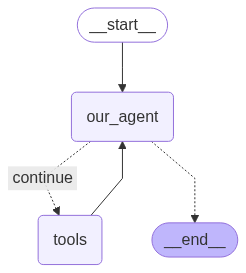

In [71]:
app

In [77]:
def print_Stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(message)

input = {"messages": [("user", "add 3+4.")]}
print_Stream(app.invoke(input, stream_mode="values"))

TypeError: string indices must be integers

In [75]:
input={"message":[("user","add 3+4.")]}
print_Stream(app.invoke(input,stream_mode="values"))

TypeError: string indices must be integers